# Practical session n°6

Notions:
- Generative Adversarial Networks
- Mode Collapse
- Wasserstein GAN
- Conditional GAN


Duration: 2 h

With this notebook, we aim to characterize a distribution in an image domain, rather than at the pixel level.

In high dimensions, especially on real images, the joint distribution is not modelable. It is not feasible to seek its density. However, we can attempt to sample from this distribution by relying on an existing set of images.
We will start by doing this without worrying about the conditional aspect:
in **Exercise 1**, the goal is to build a **generative model** that samples a domain of synthetic images.

Most recent generative models are primarily constructed from deep neural networks. In the field of image generation, one of the main approaches is based on **GANs** (Generative Adversarial Networks). **Exercise 1** illustrates this approach in its simplest version, while **Exercise 2** presents some variations.
Finally, **Exercise 3** gives us the opportunity to work on the conditional aspect. The GAN approach is modified to sample from an implicit conditional distribution.

**Exercise 1** A first GAN.



The principle of GAN is simple. We have:
- A random vector $Z$, sampled from a simple distribution, for example, a centered reduced Gaussian vector.
- A generative network $G_\theta$ ($\theta$ represents the generator's weights) that generates an image $G_\theta(Z)$.
- A discriminator network $D_\rho$ ($\rho$ represents the discriminator's weights), ending with a sigmoid function that classifies an image $x$ as "real" ($D_\rho(x) > 0.5$) or "fake" ($D_\rho(x) < 0.5$).

In the following, we omit the notations $\rho$ and $\theta$.

The algorithm consists of training $G$ and $D$ on adversarial tasks:
- $D_\rho$ is trained to distinguish images from the dataset ($x^{(i)}$) from images generated by $G_\theta$ (denoted as $G(z^{(i)})$). In the [original GAN paper](https://arxiv.org/abs/1406.2661), the authors use cross-entropy as the cost function. For a pair of two images, one fake and the other real, the cost is written as:
  $$  - {\bigg [} \ln(D(x^{(i)})) + \ln(1 - D(G(z^{(i)})) {\bigg ]}$$

- $G_\theta$ is trained to "fool" the discriminator with the adversarial cost function:
  $$  \ln(1 - D(G(z^{(i)}))) $$

A theoretical analysis of the problem is covered in the supplementary exercise sheet. Here, we implement the algorithm on synthetic images.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, models, transforms

In [2]:
! git clone https://github.com/nanopiero/ML_S5_etudiants


Cloning into 'ML_S5_etudiants'...
remote: Enumerating objects: 188, done.
remote: Counting objects: 100% (67/67), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 188 (delta 34), reused 33 (delta 17), pack-reused 121 (from 1)
Receiving objects: 100% (188/188), 3.35 MiB | 15.12 MiB/s, done.
Resolving deltas: 100% (67/67), done.


In [11]:
! cp ML_S5_etudiants/practicals/P5/utils_P5.py .

In [13]:
from utils_P5 import gen_DCGAN, UNet, voir_batch2D

Let's first define an image generation problem. The following function samples the random image $X$ and the random vector $Z$:

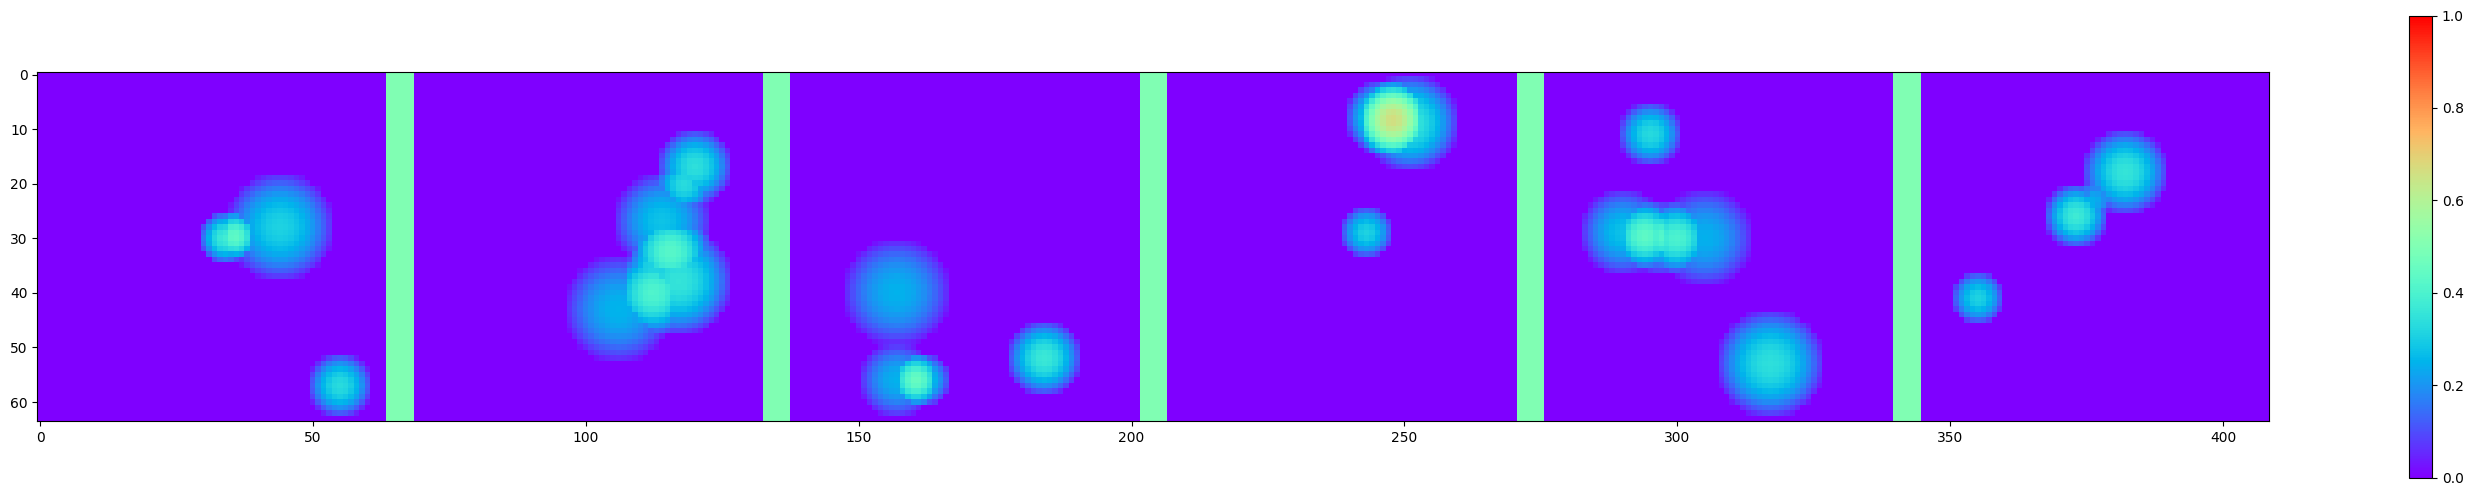

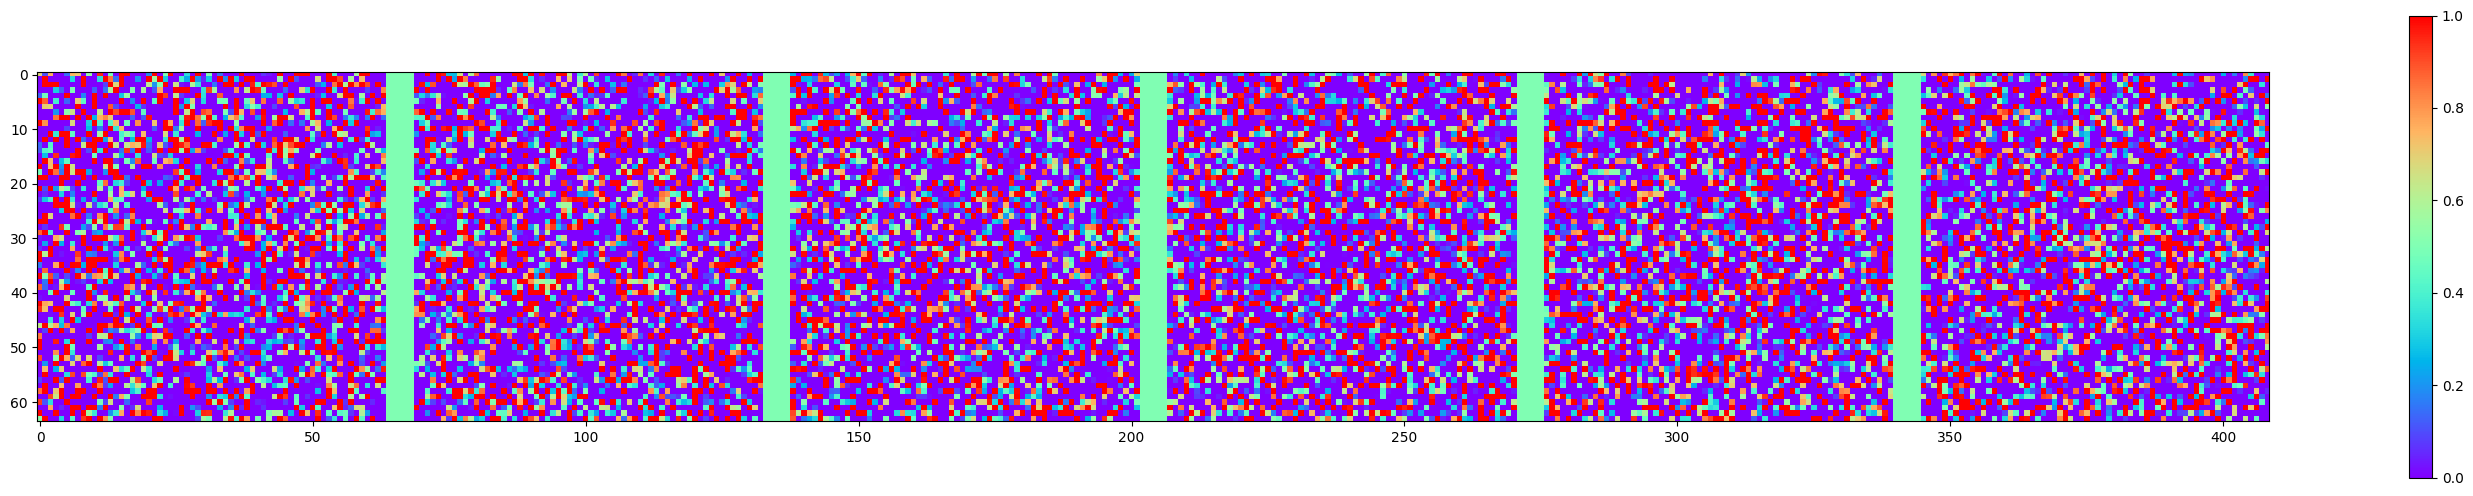

In [14]:
# Rectangle proportion in the image:
lambda_rec = 0.0

x, z = gen_DCGAN(6, lambda_rec=lambda_rec)

# Clean versions (individual cells)
fig1 = plt.figure(1, figsize=(36, 6))
voir_batch2D(x, 6, fig1, k=0, min_scale=0, max_scale=1)

fig3 = plt.figure(3, figsize=(36, 6))
voir_batch2D(z, 6, fig3, k=0, min_scale=0, max_scale=1)

**Q1** The vector $Z$ is an image. What type of network is suitable for $G$? Instantiate it.

In [22]:
n_channels, n_classes, size = 1, 1, 8

netG = UNet(n_channels, n_classes, size).cuda()


**Q2** The Discriminator class is used to encode the discriminator. Instantiate it and use the *weight_init* function to initialize the network's weights. What type of network do you obtain in this way?

In [23]:
ndf = 32
nc = 1


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

netD = Discriminator().cuda()
netD.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): LeakyReLU(negative_slope=0.2, inplace=True)
    (7): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (10): Sigmoid()
  )
)

Let's now specify some training parameters (most of them are standard for GANs):

In [24]:
# Fixing the seed (to reproduce results)
manualSeed = 1
import random
random.seed(manualSeed)
torch.manual_seed(manualSeed)

# Number of parallel processes:
workers = 2

# Image size
image_size = 64

# Number of channels
nc = 1

# Batch size
batch_size = 64

# Number of batches per epoch
num_batches = 200
num_epochs = 10

# Learning rate
lr = 0.0002

# Beta1 hyperparameter for Adam
beta1 = 0.5  # Sometimes simply 0.

# Cross-entropy
criterion = nn.BCELoss()

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [25]:
# To observe how G(z) evolves with z fixed along the training:
_ , fixed_z = gen_DCGAN(batch_size, lambda_rec=lambda_rec)
fixed_z = fixed_z.cuda()

**Q3** Add comments to the following snippet. Why *D_fake* and *D_fake2* are computed ? How could these variables be interpreted ?

In [26]:
# Lists for stats
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")

for epoch in range(num_epochs):
    for i in range(num_batches):

        # Sampling X and Z
        x, z = gen_DCGAN(batch_size, lambda_rec=lambda_rec)

        # Real images
        x = x.cuda()

        # White noise
        z = z.cuda()

        # STEP 1: Discriminator optimization
        netD.zero_grad()
        D_real = netD(x).view(-1)
        label = torch.ones((batch_size,)).cuda()
        errD_real = criterion(D_real, label)
        errD_real.backward()

        # To display D_real
        D_real = D_real.mean().item()

        fake = netG(z)
        D_fake = netD(fake.detach()).view(-1)
        label.fill_(0.)
        errD_fake = criterion(D_fake, label)
        errD_fake.backward()
        errD = errD_real + errD_fake
        optimizerD.step()

        # To display D_fake
        D_fake = D_fake.mean().item()


        # STEP 2: Generator optimization
        netG.zero_grad()
        D_fake2 = netD(fake).view(-1)
        label.fill_(1.)
        errG = criterion(D_fake2, label)
        errG.backward()

        # To display D_fake2
        D_fake2 = D_fake2.mean().item()
        optimizerG.step()

        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, num_batches,
                     errD.item(), errG.item(), D_real, D_fake, D_fake2))

        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Store generated images from "fixed_z" every hundred epochs
        if (iters % 100 == 0) or ((epoch == num_epochs - 1) and (i == num_batches - 1)):
            with torch.no_grad():
                fake = netG(fixed_z).detach().cpu()
            img_list.append(fake)
        iters += 1

Starting Training Loop...
[0/10][0/200]	Loss_D: 1.3418	Loss_G: 1.2234	D(x): 0.4919	D(G(z)): 0.4657 / 0.2965
[0/10][50/200]	Loss_D: 0.0027	Loss_G: 7.5922	D(x): 0.9983	D(G(z)): 0.0009 / 0.0007
[0/10][100/200]	Loss_D: 0.0011	Loss_G: 8.4617	D(x): 0.9994	D(G(z)): 0.0005 / 0.0002
[0/10][150/200]	Loss_D: 0.0492	Loss_G: 5.4624	D(x): 0.9579	D(G(z)): 0.0048 / 0.0045
[1/10][0/200]	Loss_D: 0.0608	Loss_G: 4.6003	D(x): 0.9805	D(G(z)): 0.0401 / 0.0103
[1/10][50/200]	Loss_D: 0.1290	Loss_G: 3.2237	D(x): 0.9111	D(G(z)): 0.0292 / 0.0405
[1/10][100/200]	Loss_D: 0.0883	Loss_G: 2.7295	D(x): 0.9643	D(G(z)): 0.0447 / 0.0659
[1/10][150/200]	Loss_D: 0.0983	Loss_G: 3.4373	D(x): 0.9781	D(G(z)): 0.0692 / 0.0326
[2/10][0/200]	Loss_D: 0.0542	Loss_G: 4.1068	D(x): 0.9747	D(G(z)): 0.0118 / 0.0167
[2/10][50/200]	Loss_D: 0.1717	Loss_G: 4.0960	D(x): 0.9843	D(G(z)): 0.1390 / 0.0167
[2/10][100/200]	Loss_D: 0.4779	Loss_G: 3.8704	D(x): 0.8786	D(G(z)): 0.0760 / 0.0210
[2/10][150/200]	Loss_D: 0.0219	Loss_G: 4.0642	D(x): 0.9980	

**Q4** Plot the evolution of the cost functions for the generator and discriminator. Visualize the successive images. Comment.

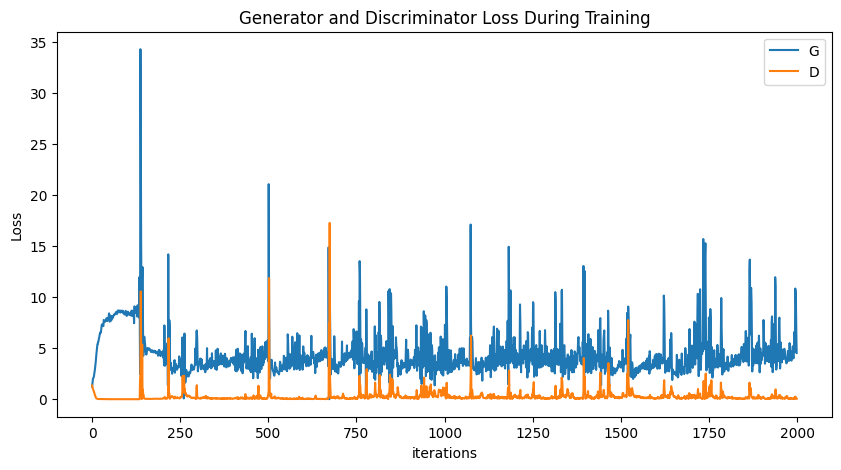

In [27]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

2


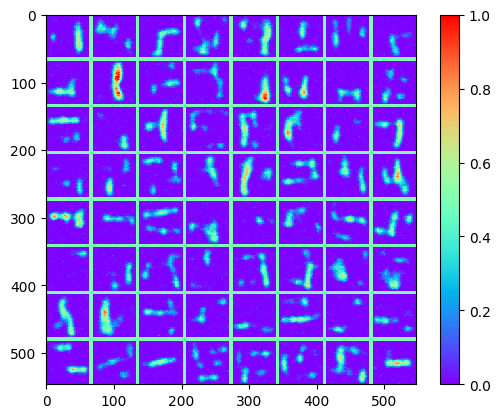

2


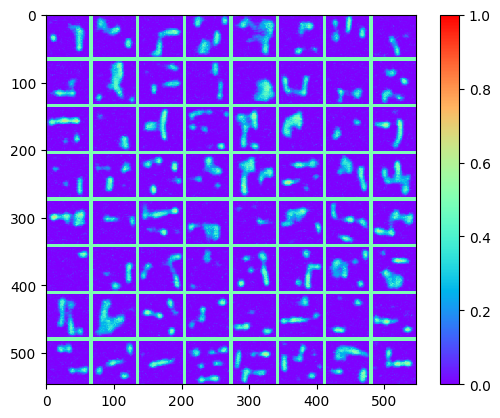

In [46]:
for k, img in enumerate(img_list):
  plt.figure(k)
  print(len(img_list))
  voir_batch2D(img_list[k], 8, fig1, k=0, min_scale=0,max_scale=1)

**Q5** Give a qualitative and and quantitative analysis of the outputs of the generator after these few epochs.

**Q6** Restart training with additional rectangles on the image. Visualize and comment on the results.

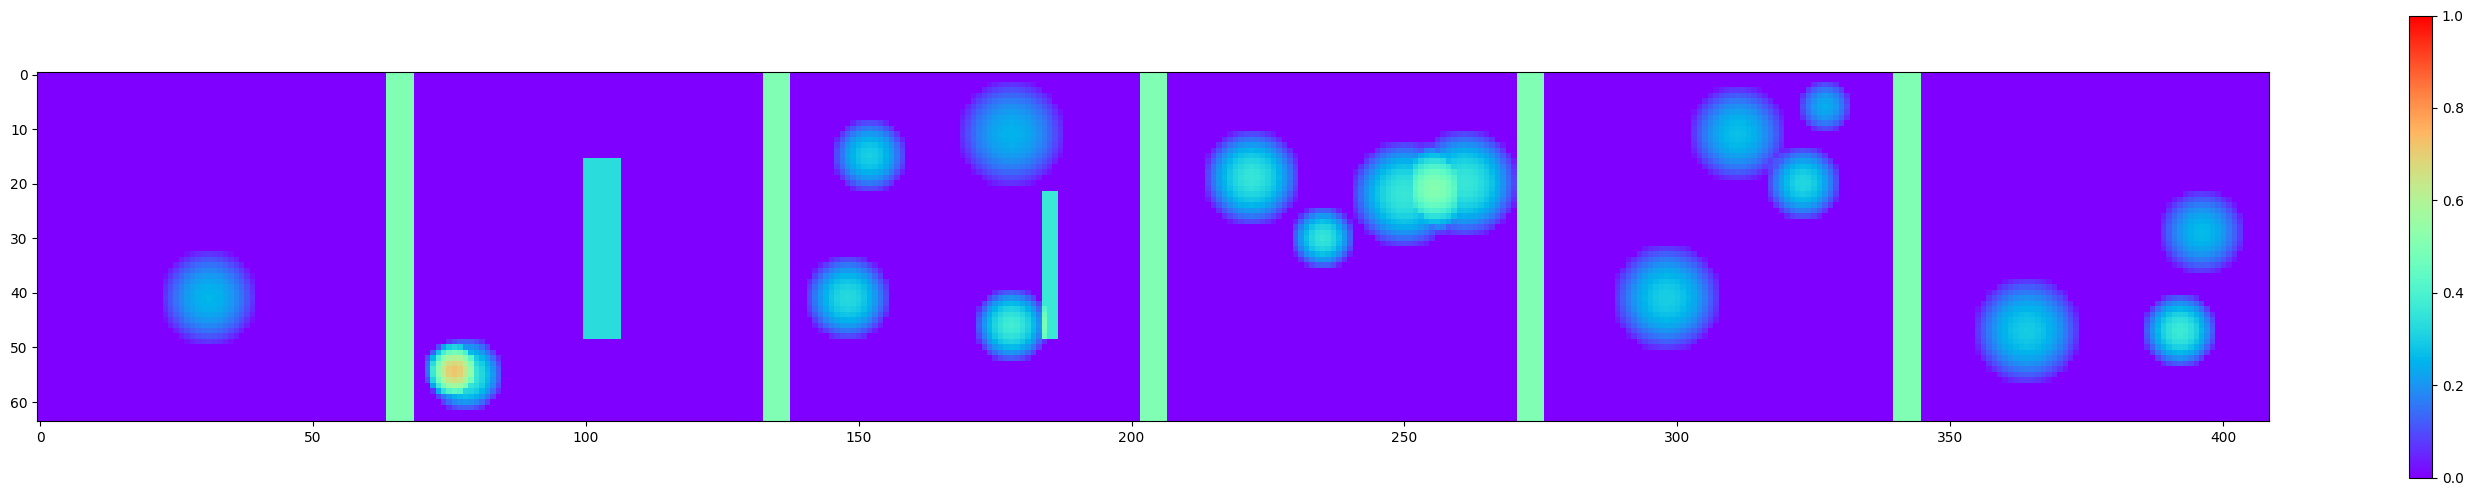

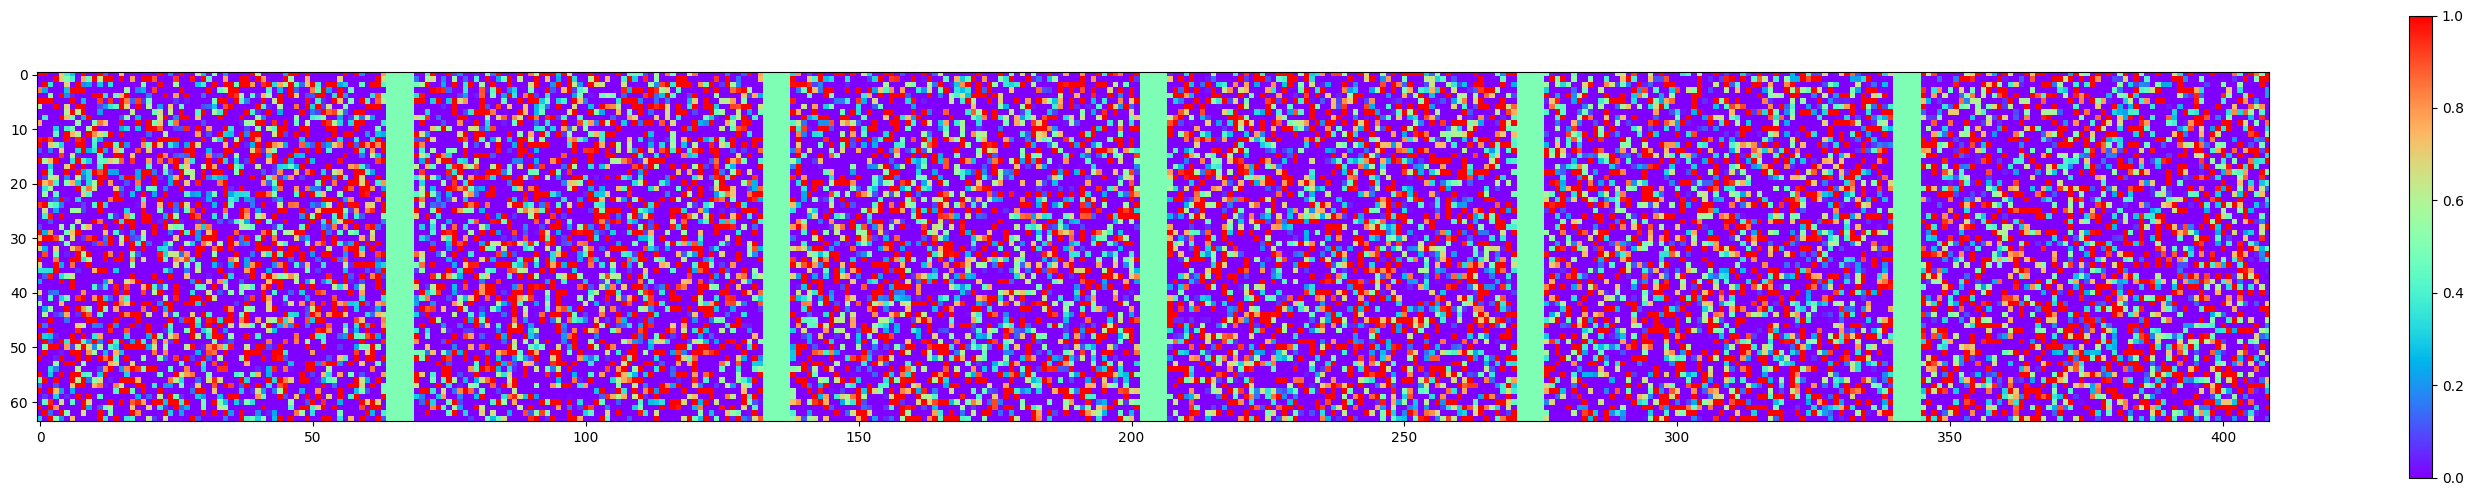

In [29]:
# Rectangle proportion in the image :
lambda_rec = 0.00025

x , z = gen_DCGAN(6, lambda_rec = lambda_rec)

# Propre versions (only cells)
fig1 = plt.figure(1, figsize=(36, 6))
voir_batch2D(x, 6, fig1, k=0, min_scale=0,max_scale=1)


fig3 = plt.figure(3, figsize=(36, 6))
voir_batch2D(z, 6, fig3, k=0, min_scale=0,max_scale=1)

**Exercise n°2** Wasserstein-GANs.

To facilitate the convergence of GANs, several approaches have been explored. In particular:
- Giving the discriminator more time to converge at each step.
- Use different cost functions
- Keep the Lipschitzianity of the discriminator. This option takes its root in an interesting theoretical approach (see the supplementary exercise sheet). It can be done:

  * by constraining the weights of the discriminator to remain within a given interval (see the paper introducing WGANs [(Wasserstein-GANs)](https://arxiv.org/abs/1701.07875).

  * by [gradient penalization](https://arxiv.org/pdf/1704.00028.pdf)   

**Q2** In the following cells, these four ideas are implemented. Say where.

In [30]:
nc = 1
ndf = 32

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
        )

    def forward(self, input):
        return self.main(input)

In [31]:
def calculate_gradient_penalty(model, real_images, fake_images):
    alpha = torch.randn((real_images.size(0), 1, 1, 1)).cuda()
    interpolates = (alpha * real_images + ((1 - alpha) * fake_images)).requires_grad_(True)

    model_interpolates = model(interpolates)
    grad_outputs = torch.ones(model_interpolates.size(), requires_grad=False).cuda()

    # Get gradient w.r.t. interpolates
    gradients = torch.autograd.grad(
        outputs=model_interpolates,
        inputs=interpolates,
        grad_outputs=grad_outputs,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = torch.mean((gradients.norm(2, dim=1) - 1) ** 2)
    return gradient_penalty

In [32]:
n_channels, n_classes,size = 1, 1, 16
netG = UNet(n_channels, n_classes, size).cuda()
netD = Discriminator()
netD.apply(weights_init)
netD = netD.cuda()

In [33]:
# Proportion of rectangle in the image:
lambda_rec = 0.00025

# Fixing the seed for reproducibility:
manualSeed = 1
torch.manual_seed(manualSeed)

# Number of parallel processes:
workers = 2

# Image size:
image_size = 64

# Number of channels:
nc = 1

# Batch size:
batch_size = 64

# Number of batches per epoch (for the generator):
num_batches_generator = 200
num_epochs = 30

# Learning rate:
lr = 0.0001

# Beta1 hyperparameter for Adam:
beta1 = 0.  # In the paper introducing gradient penalty

# Number of GPUs:
ngpu = 1

# Cross-entropy & label conventions:
criterion = nn.BCELoss()

# Gradient penalty (gp) or classic WGAN:
add_gp = True

# Setup Adam optimizers for both G and D:
# If gradient penalty:
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))
# If not:
# optimizerD = optim.RMSprop(netD.parameters(), lr=lr)
# optimizerG = optim.RMSprop(netG.parameters(), lr=lr)

# Schedulers:
step_size = 31
gamma = 0.2
schedulerD = torch.optim.lr_scheduler.StepLR(optimizerD, step_size=step_size, gamma=gamma)
schedulerG = torch.optim.lr_scheduler.StepLR(optimizerG, step_size=step_size, gamma=gamma)

In [34]:
# To observe how G(z) evolves with fixed z during training:
_ ,  fixed_z = gen_DCGAN(batch_size, lambda_rec=lambda_rec)
fixed_z = fixed_z.cuda()

In [42]:
img_list = []
G_losses = []
D_losses = []

n_critic = 5
clip = 0.01

print("Starting Training Loop...")

for epoch in range(num_epochs):
    for i in range(num_batches_generator):
        netG.train()
        for j in range(n_critic):
            x , z = gen_DCGAN(batch_size, lambda_rec=lambda_rec)
            ############################
            # (1) Update netD network:
            ###########################
            netD.zero_grad()
            real = x.cuda()
            output_real = netD(real)
            fake = netG(z.cuda())
            output_fake = netD(fake.detach())

            if add_gp:
                gradient_penalty = calculate_gradient_penalty(netD,
                                                   real.data, fake.data)
                errD = output_fake.mean() - output_real.mean() + 10 * gradient_penalty

            else :
                errD = output_fake.mean() - output_real.mean()

            errD.backward()

            optimizerD.step()

            if not add_gp:
                for p in netD.parameters():
                    p.data.clamp_(-clip, clip)

        ############################
        # (2) Update netG network:
        ###########################
        netG.zero_grad()

        fake = netG(z.cuda())
        output_fake = netD(fake).view(-1)

        errG = -output_fake.mean()

        errG.backward()

        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f'
                  % (epoch+1, num_epochs, i, num_batches_generator,
                     errD.item()))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise

    with torch.no_grad():
        netG.eval()
        fake = netG(fixed_z.cuda()).detach().cpu()
#            img_list.append(vutils.make_grid(fake, padding=2, normalize=False))
    img_list.append(fake)


    schedulerD.step()
    schedulerG.step()


Starting Training Loop...
[1/30][0/200]	Loss_D: -1.3504
[1/30][50/200]	Loss_D: -1.0172
[1/30][100/200]	Loss_D: -0.8996
[1/30][150/200]	Loss_D: -0.8517
[2/30][0/200]	Loss_D: -0.7770
[2/30][50/200]	Loss_D: -0.7001
[2/30][100/200]	Loss_D: -0.6458
[2/30][150/200]	Loss_D: -0.5592
[3/30][0/200]	Loss_D: -0.5278
[3/30][50/200]	Loss_D: -0.5875
[3/30][100/200]	Loss_D: -0.5258


KeyboardInterrupt: 

**Q3** Can we still observe mode collapse in these images?

**Q4** Let's finally see the results of training over several hours. Load the UNet trained for 600 epochs (*netG_600.pt*) and visualize the generated images.

In [50]:
! pip install huggingface_hub
from huggingface_hub import hf_hub_download
model_hf_name = "P6_Ex2_netG_600ep_WGP_lr0001.pt"
path_netG = hf_hub_download(repo_id="nanopiero/models_ML_S5_P6", filename=model_hf_name)

In [48]:
n_channels, n_classes,size = 1, 1, 16
netG_600ep = UNet(n_channels, n_classes, size).cuda()


In [51]:
netG_600ep.load_state_dict(torch.load(model_hf_name))

# Générer une image
with torch.no_grad():
    generated_image = netG_600ep(z.cuda()).detach().cpu()

# Afficher l'image en utilisant voir_batch2D
voir_batch2D(generated_image, 6, fig1, k=0, min_scale=0, max_scale=1)

<ipython-input-51-5f60db36ecbe>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  netG_600ep.load_state_dict(torch.load(model_hf_name))


FileNotFoundError: [Errno 2] No such file or directory: 'P6_Ex2_netG_600ep_WGP_lr0001.pt'

**Exercice n°3** A conditional GAN.  




In this exercise, the goal is to implement a conditional Wasserstein-GAN. Once again, theoretical aspects are set aside; the objective is solely to construct the training loop.
The context is as follows: we have a set of images representing a domain 𝒟.
The traditional GAN generates new images from 𝒟. In this exercise, we will generate images compatible with a given list of pixel values a priori.

The following cells allow visualization of the available dataset.


In [37]:
from utils_P5 import gen_condDCGAN, UNet, voir_batch2D

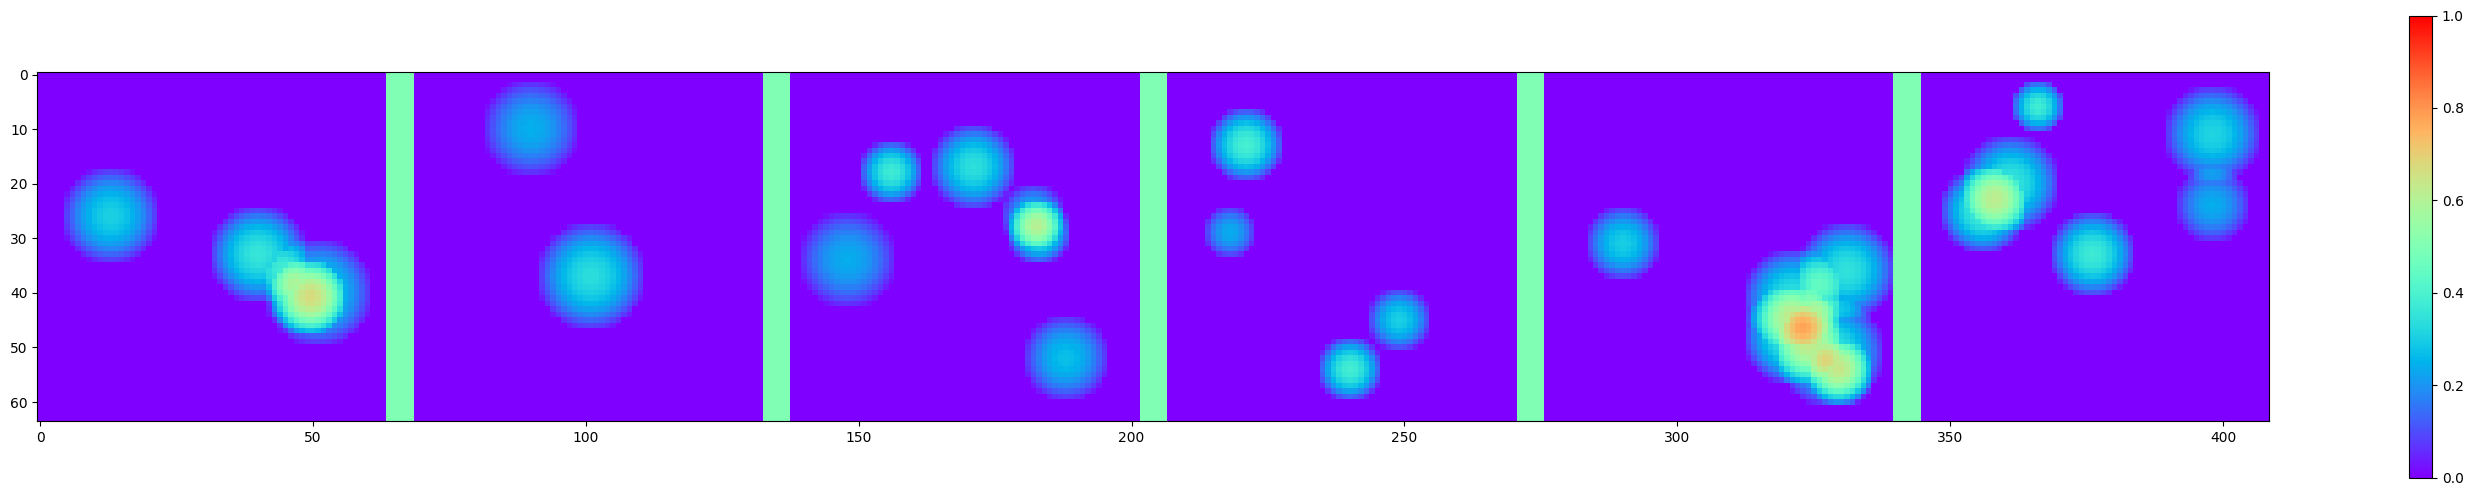

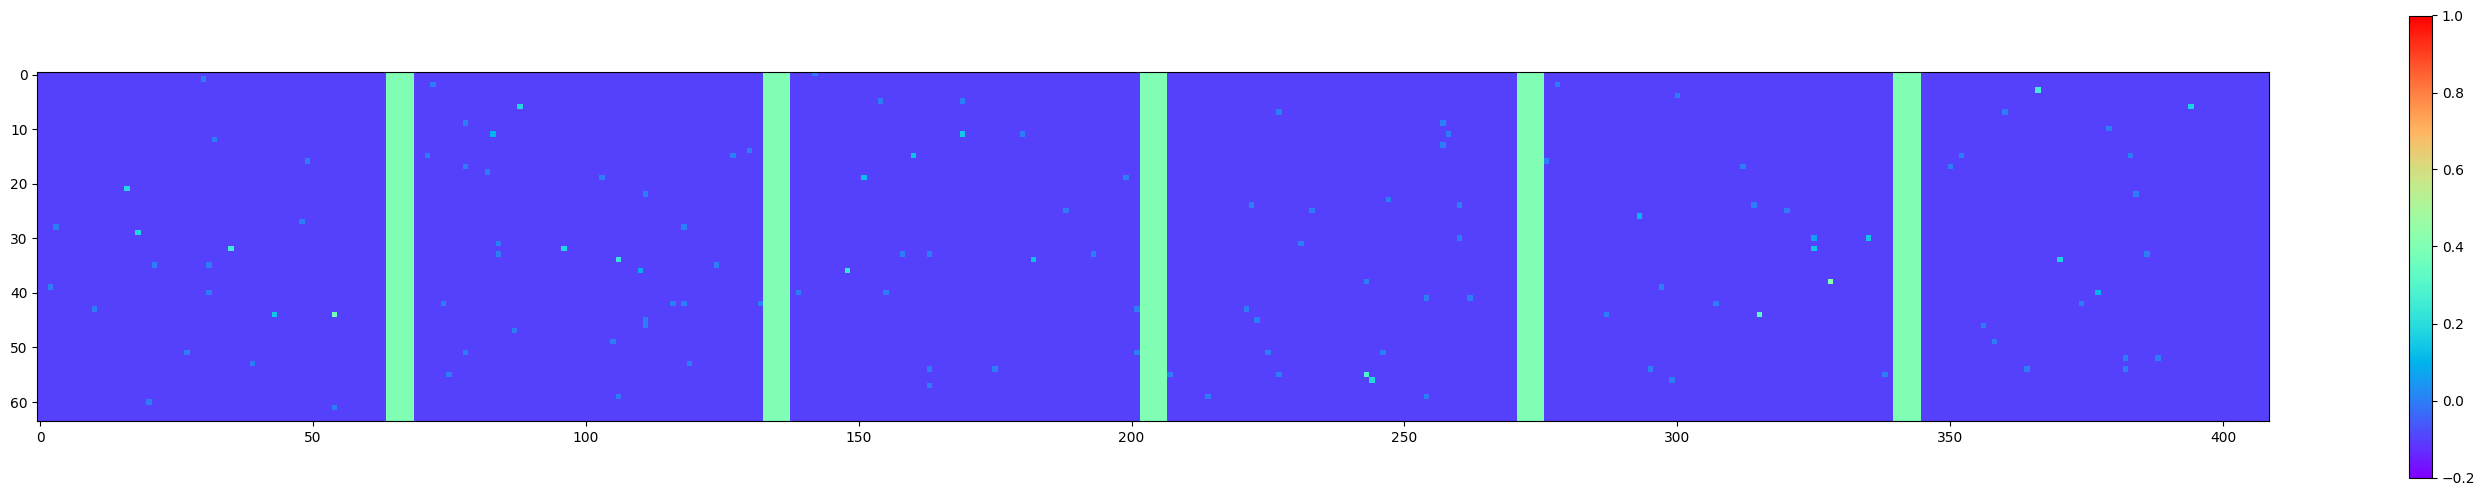

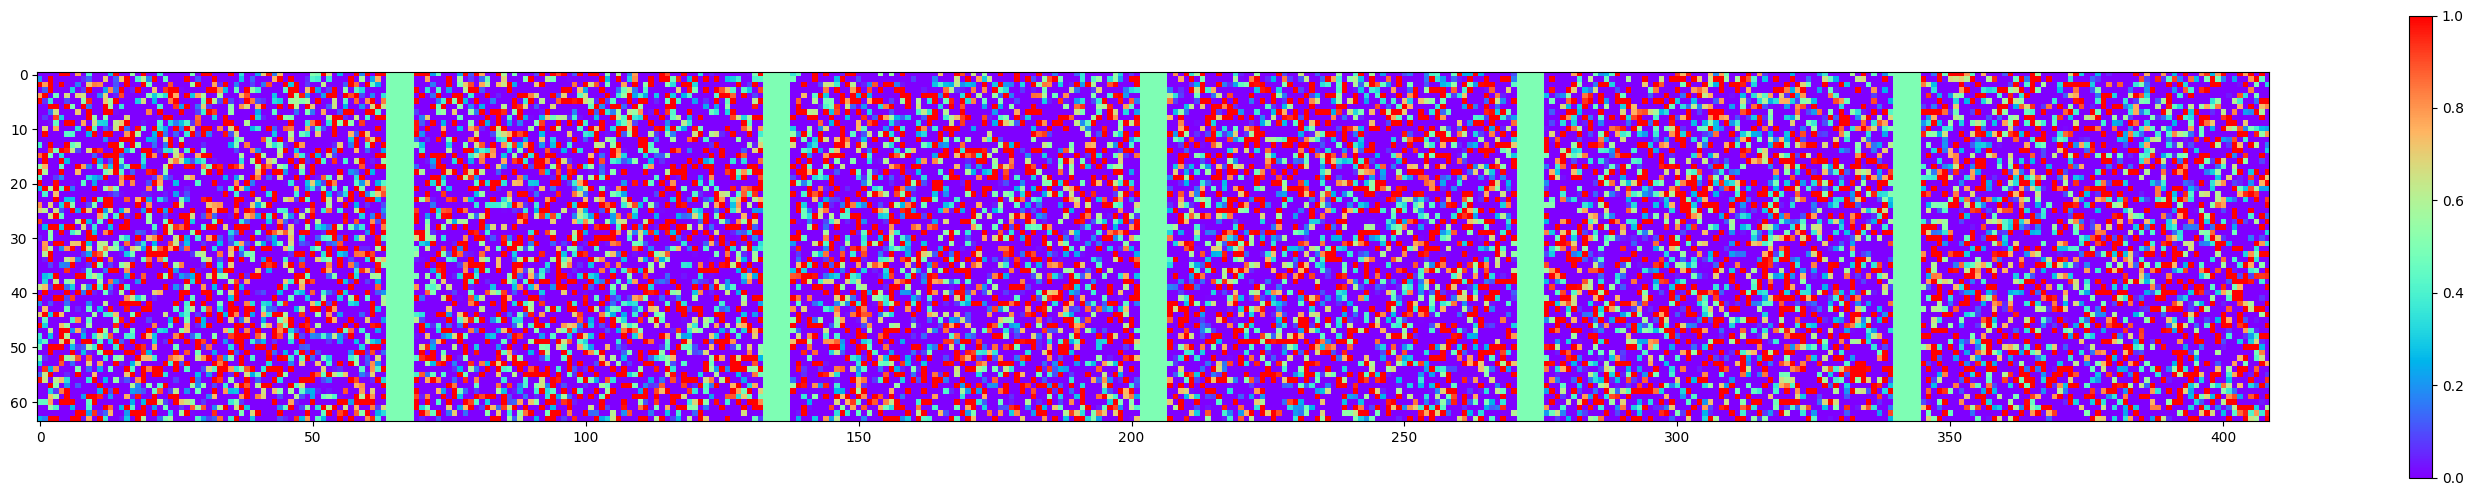

In [45]:
# Proportion of pixels preserved in yi:
obs_density = 0.005
x, y, z = gen_condDCGAN(6, obs_density)

# Full images xi
fig1 = plt.figure(1, figsize=(36, 6))
voir_batch2D(x, 6, fig1, k=0, min_scale=0, max_scale=1)

# Fragmentary images yi: a few pixels randomly sampled from xi
fig2 = plt.figure(2, figsize=(36, 6))
voir_batch2D(y, 6, fig2, k=0, min_scale=-0.2, max_scale=1)

# zi: sample from a centered reduced Gaussian vector
fig3 = plt.figure(3, figsize=(36, 6))
voir_batch2D(z, 6, fig3, k=0, min_scale=0, max_scale=1)

**Q1** Drawing inspiration from the previous exercise, complete the training loop and run it for ten epochs:

In [41]:
img_list = []
G_losses = []
D_losses = []

n_critic = 5
clip = 0.01

print("Starting Training Loop...")

for epoch in range(num_epochs):
    for i in range(num_batches_generator):
        netG.train()
        for j in range(n_critic):
            x ,y, z = gen_condDCGAN(batch_size, obs_density)
            ############################
            # (1) Update netD network:
            ###########################
            netD.zero_grad()
            real = x.cuda()
            output_real = netD(real)
            fake = netG(z.cuda())
            output_fake = netD(fake.detach())

            if add_gp:
                gradient_penalty = calculate_gradient_penalty(netD,
                                                   real.data, fake.data)
                errD = output_fake.mean() - output_real.mean() + 10 * gradient_penalty

            else :
                errD = output_fake.mean() - output_real.mean()

            errD.backward()

            optimizerD.step()

            if not add_gp:
                for p in netD.parameters():
                    p.data.clamp_(-clip, clip)

        ############################
        # (2) Update netG network:
        ###########################
        netG.zero_grad()

        fake = netG(z.cuda())
        output_fake = netD(fake).view(-1)

        errG = -output_fake.mean()

        errG.backward()

        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f'
                  % (epoch+1, num_epochs, i, num_batches_generator,
                     errD.item()))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise

    with torch.no_grad():
        netG.eval()
        fake = netG(fixed_z.cuda()).detach().cpu()
#            img_list.append(vutils.make_grid(fake, padding=2, normalize=False))
    img_list.append(fake)


    schedulerD.step()
    schedulerG.step()


Starting Training Loop...
[1/30][0/200]	Loss_D: -13.4815
[1/30][50/200]	Loss_D: -7.3188
[1/30][100/200]	Loss_D: -4.2330
[1/30][150/200]	Loss_D: -2.9065
[2/30][0/200]	Loss_D: -2.2612
[2/30][50/200]	Loss_D: -1.8519
[2/30][100/200]	Loss_D: -1.5845
[2/30][150/200]	Loss_D: -1.3213


KeyboardInterrupt: 

**Q2** Visualize some images and comment on them.

In [ ]:
print(len(img_list))
voir_batch2D(img_list[-1], 8, fig1, k=0, min_scale=0,max_scale=1)

**Q3** To obtain a GAN that takes into account the condition contained in $y_i$, it is necessary to push the training further. The file *P6_Ex3_netG_300ep_WGP_scheduler75_lr005.pt* contains the weights obtained after training for 300 epochs. Load these weights and visualize several images for the same inputs $x_i$ and $z_i$. Check the coherence and draw conclusions.